In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [3]:
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [90]:
xysize = 256
xysize_latent = 64
timesteps = 501

train_test_split_index = 450


# xysize = 384
# xysize_latent = 96
# timesteps = 399

# train_test_split_index = 300

### Load flow data

In [9]:
# Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Velocity_{}_{}_326464.npy'.format(xysize, xysize))

Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Velocity_256_256_326464.npy')

Latent_data_Velocity = Latent_data_Velocity.reshape(timesteps, 32, xysize_latent, xysize_latent)
print(Latent_data_Velocity.shape)

(501, 32, 64, 64)


In [10]:
# training set
Latent_data_Velocity_training = Latent_data_Velocity[:train_test_split_index,:,:,:]

In [11]:
# test set
Latent_data_Velocity_test = Latent_data_Velocity[train_test_split_index:,:,:,:]

In [12]:
# # save training and test sets
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_training.npy', Latent_data_Velocity_training)
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_test.npy', Latent_data_Velocity_test)

### Load building data

In [14]:
# Latent_data_Building = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_{}_{}_326464.npy'.format(xysize, xysize))
Latent_data_Building = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_166464.npy")
Latent_data_Building = Latent_data_Building.reshape(1, 16, xysize_latent, xysize_latent)
print(Latent_data_Building.shape)

(1, 16, 64, 64)


(1, 16, 64, 64)
torch.Size([16, 64, 64])
(1, 256, 256)


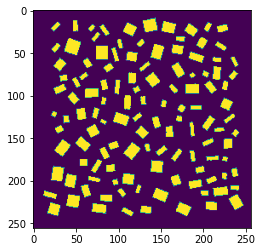

In [15]:
# Load the saved cae for building

## for building
class Autoencoder_building(nn.Module):
    def __init__(self):
        super(Autoencoder_building, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_building = Autoencoder_building()  # Assuming you have the ConvAutoencoder class defined
autoencoder_building.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/autoencoder_Flow_Building_256_256_2000epochs.pth'))

autoencoder_building.eval()  # Set the autoencoder to evaluation mode

print(Latent_data_Building.shape)
input_data = torch.from_numpy(Latent_data_Building[0]).float()
print(input_data.shape)
res = autoencoder_building.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

plt.figure()
plt.imshow(output_data[0])

In [16]:
# Set a seed for reproducibility
np.random.seed(42)

# Get the indices of 0 values
sensors_indices = np.argwhere(output_data <= 0.00001)

# Number of points to randomly select
num_points_to_select = 10

# Randomly select indices
selected_indices = sensors_indices[np.random.choice(len(sensors_indices), size=num_points_to_select, replace=False)]

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
[[  0  37  66]
 [  0 102  27]
 [  0  87 148]
 [  0  67 245]
 [  0 105 156]
 [  0 195 133]
 [  0  78 130]
 [  0 181 199]
 [  0 177  70]
 [  0 166 103]]


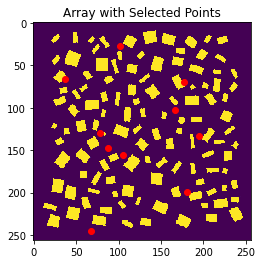

In [17]:
# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

plt.title('Array with Selected Points')
plt.show()

In [18]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

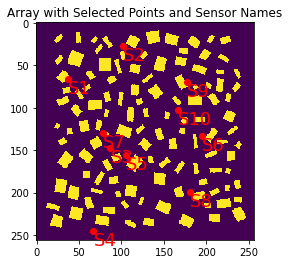

In [19]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


#### Create sensors

In [20]:
sensors_x = selected_indices[:, 1]
sensors_y = selected_indices[:, 2]

### Combine Velocity and Building

In [21]:
n_sampels = 200
t_gaps_sampels = 1  ## 10 used to train the model
dt = 5
ntimes = 3

batch_size = 16  # Choose your desired batch size

samples_training = []
samples_training_X = []
samples_training_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_training[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_training[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X 3 timesteps
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X 2 timesteps
    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    # ss_1 = ss_0

    ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_training.append(ss)
    samples_training_X.append(ss_0)
    samples_training_Y.append(ss_1) # Set the autoencoder to evaluation mode

(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 

In [22]:
samples_training_X_stacked = (np.stack(samples_training_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_training_X_stacked.shape)

(200, 80, 64, 64)


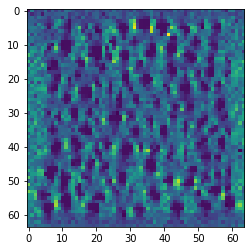

In [23]:
plt.imshow(samples_training_X_stacked[0][0])

In [24]:
samples_training_Y_stacked = (np.stack(samples_training_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_training_Y_stacked.shape)

(200, 32, 64, 64)


(array([246904.,  69349.,   5555.,   1814.,    783.,    908.,    769.,
           641.,    553.,    404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

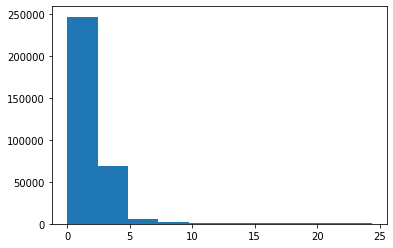

In [25]:
plt.hist(samples_training_X_stacked[0].flatten())

(array([26042., 29981.,  3704.,  1751.,   783.,   908.,   769.,   641.,
          553.,   404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

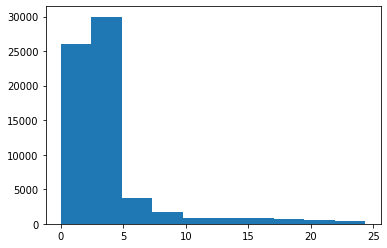

In [26]:
plt.hist(Latent_data_Building.flatten())

## Create data loader

In [27]:
data = samples_training
print(len(data))

200


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {'input': self.data_x[idx], 'target': self.data_y[idx]}
        return sample

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Create a DataLoader for batching and shuffling the data
shuffle = False  # Set to True if you want to shuffle the data during training

data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)


## Define the model

In [24]:
# Encoder and Decoder (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.decoder(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated


## Train model

In [62]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)

Epoch [1/300], AE Loss: 1.0438, D Loss: 0.7144
Epoch [2/300], AE Loss: 0.1769, D Loss: 0.1316
Epoch [3/300], AE Loss: 0.1413, D Loss: 0.0578
Epoch [4/300], AE Loss: 0.1247, D Loss: 0.0327
Epoch [5/300], AE Loss: 0.1135, D Loss: 0.0218
Epoch [6/300], AE Loss: 0.1060, D Loss: 0.0169
Epoch [7/300], AE Loss: 0.0997, D Loss: 0.0131
Epoch [8/300], AE Loss: 0.0946, D Loss: 0.0121
Epoch [9/300], AE Loss: 0.0903, D Loss: 0.0094
Epoch [10/300], AE Loss: 0.0865, D Loss: 0.0074
Epoch [11/300], AE Loss: 0.0831, D Loss: 0.0063
Epoch [12/300], AE Loss: 0.0802, D Loss: 0.0056
Epoch [13/300], AE Loss: 0.0773, D Loss: 0.0050
Epoch [14/300], AE Loss: 0.0752, D Loss: 0.0046
Epoch [15/300], AE Loss: 0.0735, D Loss: 0.0045
Epoch [16/300], AE Loss: 0.0719, D Loss: 0.0043
Epoch [17/300], AE Loss: 0.0705, D Loss: 0.0042
Epoch [18/300], AE Loss: 0.0694, D Loss: 0.0039
Epoch [19/300], AE Loss: 0.0682, D Loss: 0.0044
Epoch [20/300], AE Loss: 0.0672, D Loss: 0.0057
Epoch [21/300], AE Loss: 0.0658, D Loss: 0.0048
E

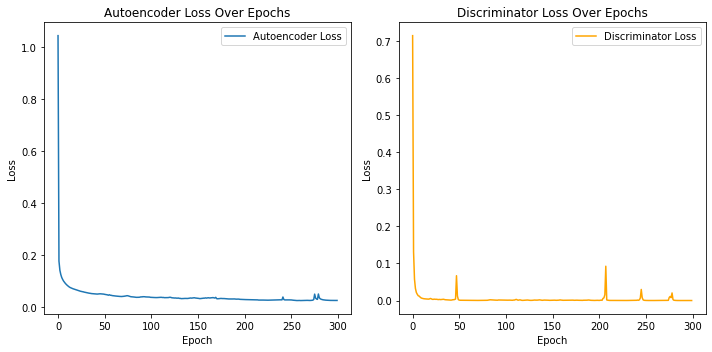

Training finished.


In [63]:
num_epochs = 300

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []

# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []

    for batch in data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 2, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 2, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")

In [64]:
aae_model.cpu()

AdversarialAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(80, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): Identity()
    )
  )
  (discriminator): Discriminator(
    (discriminator): Sequential(
      (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-0

### Save trained model

In [126]:
torch.save(aae_model.state_dict(), '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_Updated_AAE80Samples.pth'.format(num_epochs))  ### PredictionMulti

## Load saved model - AAE

In [71]:
print(ss_0.shape[1])

80


In [68]:
num_epochs = 10000
batch_size = 16


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

# Load the saved autoencoder
# Instantiate components
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
autoencoderP = AdversarialAutoencoder(encoder, decoder, discriminator)

autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_10000epochs_AAEVen200Samples_3ts.pth'))

autoencoderP.eval()  # Set the autoencoder to evaluation mode

aae_model = autoencoderP

RuntimeError: Error(s) in loading state_dict for AdversarialAutoencoder:
	size mismatch for encoder.model.0.weight: copying a param with shape torch.Size([256, 112, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 80, 3, 3]).

In [70]:
num_epochs = 300

# Load the saved autoencoder
# Instantiate components
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator)

# aae_model.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_1000epochs_AAE80Samples.pth'))

aae_model.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_{}epochs_Updated_AAE80Samples.pth'.format(num_epochs)))
aae_model.eval()  # Set the autoencoder to evaluation mode
autoencoderP = aae_model

RuntimeError: Error(s) in loading state_dict for AdversarialAutoencoder:
	Missing key(s) in state_dict: "encoder.model.0.weight", "encoder.model.0.bias", "encoder.model.2.weight", "encoder.model.2.bias", "encoder.model.4.weight", "encoder.model.4.bias", "decoder.model.0.weight", "decoder.model.2.weight". 
	Unexpected key(s) in state_dict: "encoder.encoder.0.weight", "encoder.encoder.0.bias", "encoder.encoder.2.weight", "encoder.encoder.2.bias", "encoder.encoder.2.running_mean", "encoder.encoder.2.running_var", "encoder.encoder.2.num_batches_tracked", "encoder.encoder.3.weight", "encoder.encoder.3.bias", "encoder.encoder.5.weight", "encoder.encoder.5.bias", "encoder.encoder.5.running_mean", "encoder.encoder.5.running_var", "encoder.encoder.5.num_batches_tracked", "decoder.decoder.0.weight", "decoder.decoder.0.bias", "decoder.decoder.2.weight", "decoder.decoder.2.bias", "decoder.decoder.2.running_mean", "decoder.decoder.2.running_var", "decoder.decoder.2.num_batches_tracked", "decoder.decoder.3.weight", "decoder.decoder.3.bias". 

### Load PcNN as comparison

In [29]:
### improved model
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
        )

    def forward(self, x):
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(x_encoder)
        return x_decoder

# Instantiate the improved model
model = MyModel()
model = model.float()

# Load the saved autoencoder
autoencoderP = MyModel()  # Assuming you have the ConvAutoencoder class defined
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_32batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
autoencoderP.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatent_2000epochs_AE80Samples.pth'))

autoencoderP.eval()  # Set the autoencoder to evaluation mode
aae_model = autoencoderP.cpu()

In [30]:
print(ss_0.shape)

(1, 80, 64, 64)


In [31]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the input size is (channels, height, width)
input_size = (ss_0.shape[1], ss_0.shape[2], ss_0.shape[3])

print(f"Input size: {input_size}")
summary(autoencoderP.to(device), input_size)

Input size: (80, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]         128,064
              ReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4          [-1, 128, 64, 64]         204,928
              ReLU-5          [-1, 128, 64, 64]               0
       BatchNorm2d-6          [-1, 128, 64, 64]             256
            Conv2d-7           [-1, 64, 64, 64]         204,864
              ReLU-8           [-1, 64, 64, 64]               0
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 32, 64, 64]          51,232
         Identity-11           [-1, 32, 64, 64]               0
Total params: 589,600
Trainable params: 589,600
Non-trainable params: 0
----------------------------------------------------------------
Input

## Generate result plots

In [32]:
def mse_loss(image1, image2):

    mse = np.mean((image1 - image2)**2)
    return mse


### Load CAE model

In [33]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [34]:
sample = Latent_data_Velocity[281]
print(sample.shape)

(32, 64, 64)


In [35]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 64, 64])
(1, 2, 256, 256)


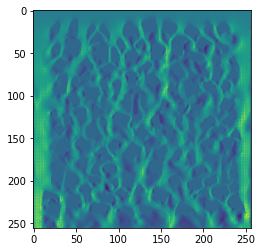

In [36]:
plt.figure()
plt.imshow(output_data[0,0])

### Predict for one sample

In [43]:
sampleX = torch.from_numpy((samples_training_X_stacked[0]).reshape(1,ss_0.shape[1],64,64)).float()
print(sampleX.shape)

torch.Size([1, 80, 64, 64])


In [46]:
with torch.no_grad():
    aae_model.eval().cpu()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

(32, 64, 64)


(array([7.9450e+03, 7.0977e+04, 3.7015e+04, 1.1566e+04, 2.3400e+03,
        8.9600e+02, 2.5500e+02, 5.8000e+01, 1.7000e+01, 3.0000e+00]),
 array([-0.53979814,  0.5901223 ,  1.7200427 ,  2.8499632 ,  3.9798837 ,
         5.109804  ,  6.239724  ,  7.3696446 ,  8.499565  ,  9.629486  ,
        10.759406  ], dtype=float32),
 <BarContainer object of 10 artists>)

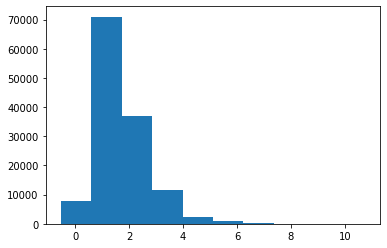

In [47]:
prediction = prediction[0].cpu().detach().numpy()
print(prediction.shape)
plt.hist(prediction.flatten())

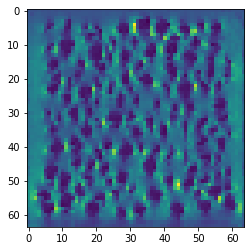

In [48]:
plt.imshow(prediction[0])

(32, 64, 64)
(2, 256, 256)


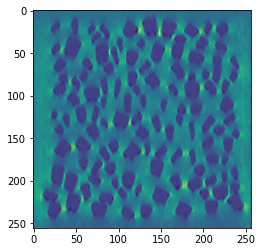

In [49]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
input_data = prediction
print(input_data.shape)
res = autoencoder.decoder(torch.from_numpy(input_data))
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0])

### Predict for training

In [87]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    print(prediction.shape)

    prediction_decoded = autoencoder.decoder(prediction[:, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [88]:
for i in range(1,18,1):
    plot_results_together(i)

torch.Size([32, 64, 64])
prediction error: 0.022717884
torch.Size([32, 64, 64])
prediction error: 0.021076543
torch.Size([32, 64, 64])
prediction error: 0.0197353
torch.Size([32, 64, 64])
prediction error: 0.018917836
torch.Size([32, 64, 64])
prediction error: 0.01867169
torch.Size([32, 64, 64])
prediction error: 0.018570295
torch.Size([32, 64, 64])
prediction error: 0.018284166
torch.Size([32, 64, 64])
prediction error: 0.017764691
torch.Size([32, 64, 64])
prediction error: 0.017327258
torch.Size([32, 64, 64])
prediction error: 0.017253583
torch.Size([32, 64, 64])
prediction error: 0.017337082
torch.Size([32, 64, 64])
prediction error: 0.017281685
torch.Size([32, 64, 64])
prediction error: 0.016990686
torch.Size([32, 64, 64])
prediction error: 0.016709562
torch.Size([32, 64, 64])
prediction error: 0.016685
torch.Size([32, 64, 64])
prediction error: 0.016909733
torch.Size([32, 64, 64])
prediction error: 0.016941333


### Predict for test

In [91]:
# test set
# Latent_data_Velocity_test = Latent_data_Velocity[timesteps - 50:,:,:,:]
Latent_data_Velocity_test = Latent_data_Velocity[train_test_split_index:,:,:,:]
print(Latent_data_Velocity_test.shape)

(51, 32, 64, 64)


In [92]:
n_sampels = 30
t_gaps_sampels = 1
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size
xysize_latent = xysize_latent

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    # ss_1 = ss_0


    ss = (ss_0, ss_1)
    # print(ss[0].shape)
    # print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
# print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
# print(samples_test_Y_stacked.shape)

In [93]:
# Plot the results together

def plot_results_together(id_sample, velocity_field):
    velocity_field = velocity_field

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # change here to switch models
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [94]:
for i in range(1,30):
    plot_results_together(i, 0)

prediction error: 0.048677266
prediction error: 0.04922725
prediction error: 0.048959743
prediction error: 0.049042497
prediction error: 0.0488364
prediction error: 0.047900278
prediction error: 0.04737177
prediction error: 0.047008246
prediction error: 0.046164338
prediction error: 0.046445556
prediction error: 0.046307627
prediction error: 0.046089638
prediction error: 0.045964483
prediction error: 0.046436686
prediction error: 0.046700504
prediction error: 0.046438478
prediction error: 0.04637654
prediction error: 0.046551853
prediction error: 0.046643928
prediction error: 0.04639978
prediction error: 0.04643654
prediction error: 0.04638379
prediction error: 0.046351846
prediction error: 0.046412297
prediction error: 0.04636726
prediction error: 0.046102133
prediction error: 0.0456368
prediction error: 0.045971405
prediction error: 0.046308294


# Predict for the whole period - Original Domain

In [66]:
# autoencoderP = aae_model
# change training or test in the next cell

### Combine Velocity and Building

In [112]:
n_sampels = 400
t_gaps_sampels = 1  ## 10 used to train the model
dt = 5
ntimes = 3

batch_size = 16  # Choose your desired batch size

samples_wholeperiod = []
samples_wholeperiod_X = []
samples_wholeperiod_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_wholeperiod[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X 3 timesteps
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X 2 timesteps
    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    # ss_1 = ss_0

    ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_wholeperiod.append(ss)
    samples_wholeperiod_X.append(ss_0)
    samples_wholeperiod_Y.append(ss_1) # Set the autoencoder to evaluation mode

(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 64, 64)
(1, 32, 64, 64)
(1, 80, 

In [113]:
samples_wholeperiod_X_stacked = (np.stack(samples_wholeperiod_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_wholeperiod_X_stacked.shape)

(400, 80, 64, 64)


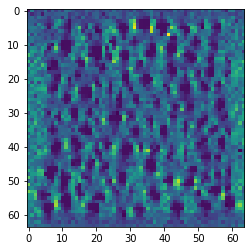

In [115]:
plt.imshow(samples_wholeperiod_X_stacked[0][0])

In [116]:
samples_wholeperiod_Y_stacked = (np.stack(samples_wholeperiod_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_wholeperiod_Y_stacked.shape)

(400, 32, 64, 64)


In [191]:

id_sample = 1
number_samples = 96

rho = 1

timelevels = []
sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []


# Initialize list to store prediction errors
prediction_errors = []

hist_data_predictions = []
hist_data_ground_truth = []
fft_data_predictions = []
fft_data_ground_truth = []

mean_values_Ytarget_u = []
mean_values_Ytarget_v = []
mean_values_prediction_u = []
mean_values_prediction_v = []

# Initialize lists to store Reynolds stress values
reynolds_stress_Ytarget_values = []
reynolds_stress_prediction_values = []

sampleX = samples_wholeperiod_X_stacked[id_sample]
sampleY = samples_wholeperiod_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

# timelevel = 450 + id_sample*t_gaps_sampels + dt*2
timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
if isinstance(prediction, tuple):
    prediction = prediction[0]

prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


# get histogram
hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

hist_data_predictions.append((hist_prediction, bins_prediction))
hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

# get FFT
fft_prediction = np.fft.fft2(prediction_decoded)
fft_ground_truth = np.fft.fft2(Y_decoded)

fft_data_predictions.append(fft_prediction)
fft_data_ground_truth.append(fft_ground_truth)

# mean values
# Calculate and store the mean values for the ground truth
print(Y_decoded.shape)
print(prediction_decoded.shape)

mean_Ytarget_u = np.mean(Y_decoded[0, 0, :, :])
mean_Ytarget_v = np.mean(Y_decoded[0, 1, :, :])
mean_values_Ytarget_u.append(mean_Ytarget_u)
mean_values_Ytarget_v.append(mean_Ytarget_v)

mean_prediction_u = np.mean(prediction_decoded[0, 0, :, :])
mean_prediction_v = np.mean(prediction_decoded[0, 1, :, :])
mean_values_prediction_u.append(mean_prediction_u)
mean_values_prediction_v.append(mean_prediction_v)

# Calculate fluctuating components for ground truth at sensor locations
u_fluct_Ytarget = Y_decoded[0, 0, sensors_x, sensors_y] - mean_Ytarget_u
v_fluct_Ytarget = Y_decoded[0, 1, sensors_x, sensors_y] - mean_Ytarget_v

# Calculate Reynolds stress for ground truth at sensor locations
reynolds_stress_Ytarget = -rho * u_fluct_Ytarget * v_fluct_Ytarget
reynolds_stress_Ytarget_values.append(reynolds_stress_Ytarget)

# Calculate fluctuating components for prediction at sensor locations
u_fluct_prediction = prediction_decoded[0, 0, sensors_x, sensors_y] - mean_prediction_u
v_fluct_prediction = prediction_decoded[0, 1, sensors_x, sensors_y] - mean_prediction_v

# Calculate Reynolds stress for prediction at sensor locations
reynolds_stress_prediction = -rho * u_fluct_prediction * v_fluct_prediction
reynolds_stress_prediction_values.append(reynolds_stress_prediction)

# get sensor data
sensor_values_prediction.append(prediction_decoded[0,:, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,:, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,:, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,:, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)
prediction_errors.append(loss)

# plt.figure()

# f, axarr = plt.subplots(1,4, figsize=(18, 9))

# # plot latent space
# # sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# # axarr[0].title.set_text('Latent X1')

# # sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# # axarr[1].title.set_text('Latent X2')

# # sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# # axarr[2].title.set_text('Latent Y_Target')

# # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# # axarr[3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[0].imshow(X1_decoded[0][:], interpolation='none')
# axarr[0].title.set_text('X1')

# sub12 = axarr[1].imshow(X2_decoded[0][:], interpolation='none')
# axarr[1].title.set_text('X2')

# sub13 = axarr[2].imshow(Y_decoded[0][:], interpolation='none')
# axarr[2].title.set_text('Y_Target')

# sub14 = axarr[3].imshow(prediction_decoded[0][:], interpolation='none')
# axarr[3].title.set_text('Y_Prediction')


n_list = [] # store the index of the sample that between the training and test set

for n in range(number_samples):    
    sampleX_new = sampleX.copy()
    sampleX_new[:32] = sampleX[32:64]
    sampleX_new[32:64] = (prediction.detach().numpy())[0]

    sampleY_new = Latent_data_Velocity[1 + id_sample*t_gaps_sampels + dt*(4 + n)]
    print(1 + id_sample*t_gaps_sampels + dt*(4 + n))
    if (1 + id_sample*t_gaps_sampels + dt*(4 + n)) > train_test_split_index:
        print("test", n)
        if not n_list:
            n_list.append(n)

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    timelevel = timelevel + dt
    timelevels.append(timelevel)
    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    # get histogram
    hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
    hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

    hist_data_predictions.append((hist_prediction, bins_prediction))
    hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

    # get FFT
    fft_prediction = np.fft.fft2(prediction_decoded)
    fft_ground_truth = np.fft.fft2(Y_decoded)

    fft_data_predictions.append(fft_prediction)
    fft_data_ground_truth.append(fft_ground_truth)


    # mean values
    # Calculate and store the mean values for the ground truth
    mean_Ytarget_u = np.mean(Y_decoded[0, 0, :, :])
    mean_Ytarget_v = np.mean(Y_decoded[0, 1, :, :])
    mean_values_Ytarget_u.append(mean_Ytarget_u)
    mean_values_Ytarget_v.append(mean_Ytarget_v)

    mean_prediction_u = np.mean(prediction_decoded[0, 0, :, :])
    mean_prediction_v = np.mean(prediction_decoded[0, 1, :, :])
    mean_values_prediction_u.append(mean_prediction_u)
    mean_values_prediction_v.append(mean_prediction_v)

    # Calculate fluctuating components for ground truth at sensor locations
    u_fluct_Ytarget = Y_decoded[0, 0, sensors_x, sensors_y] - mean_Ytarget_u
    v_fluct_Ytarget = Y_decoded[0, 1, sensors_x, sensors_y] - mean_Ytarget_v

    # Calculate Reynolds stress for ground truth at sensor locations
    reynolds_stress_Ytarget = -rho * u_fluct_Ytarget * v_fluct_Ytarget
    reynolds_stress_Ytarget_values.append(reynolds_stress_Ytarget)

    # Calculate fluctuating components for prediction at sensor locations
    u_fluct_prediction = prediction_decoded[0, 0, sensors_x, sensors_y] - mean_prediction_u
    v_fluct_prediction = prediction_decoded[0, 1, sensors_x, sensors_y] - mean_prediction_v

    # Calculate Reynolds stress for prediction at sensor locations
    reynolds_stress_prediction = -rho * u_fluct_prediction * v_fluct_prediction
    reynolds_stress_prediction_values.append(reynolds_stress_prediction)


    
    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,:, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,:, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,:, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,:, sensors_x, sensors_y])


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)
    prediction_errors.append(loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # # plot latent space
    # # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # # axarr[0].title.set_text('Latent X1')

    # # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # # axarr[1].title.set_text('Latent X2')

    # # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # # axarr[2].title.set_text('Latent Y_Target')

    # # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # # axarr[3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][:], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][:], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][:], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][:], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

(1, 2, 256, 256)
(1, 2, 256, 256)
prediction error: 0.022717884
22
prediction error: 0.06078427
27
prediction error: 0.08648954
32
prediction error: 0.12341341
37
prediction error: 0.17061111
42
prediction error: 0.21986961
47
prediction error: 0.27777183
52
prediction error: 0.3381207
57
prediction error: 0.395464
62
prediction error: 0.44781533
67
prediction error: 0.490097
72
prediction error: 0.5297922
77
prediction error: 0.5639956
82
prediction error: 0.5979145
87
prediction error: 0.63247246
92
prediction error: 0.6828664
97
prediction error: 0.7365022
102
prediction error: 0.77709305
107
prediction error: 0.80077344
112
prediction error: 0.8126557
117
prediction error: 0.8211735
122
prediction error: 0.82713586
127
prediction error: 0.8381981
132
prediction error: 0.8489704
137
prediction error: 0.8760705
142
prediction error: 0.90224445
147
prediction error: 0.9129857
152
prediction error: 0.9113594
157
prediction error: 0.90239316
162
prediction error: 0.89044726
167
predicti

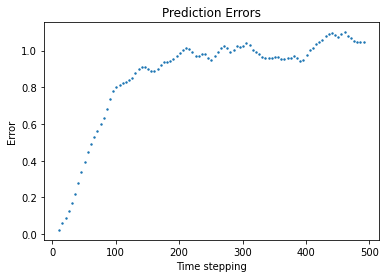

In [201]:
# Plot prediction errors
plt.figure()
plt.scatter(timelevels, prediction_errors, s=2)
plt.title('Prediction Errors')
plt.xlabel('Time stepping')
plt.ylabel('Error')
plt.show()

## Reynolds stresses

In [171]:
reynolds_stress_Ytarget_values = np.stack(reynolds_stress_Ytarget_values)
print(reynolds_stress_Ytarget_values.shape)

(97, 10)


In [172]:
reynolds_stress_prediction_values = np.stack(reynolds_stress_prediction_values)
print(reynolds_stress_prediction_values.shape)

(97, 10)


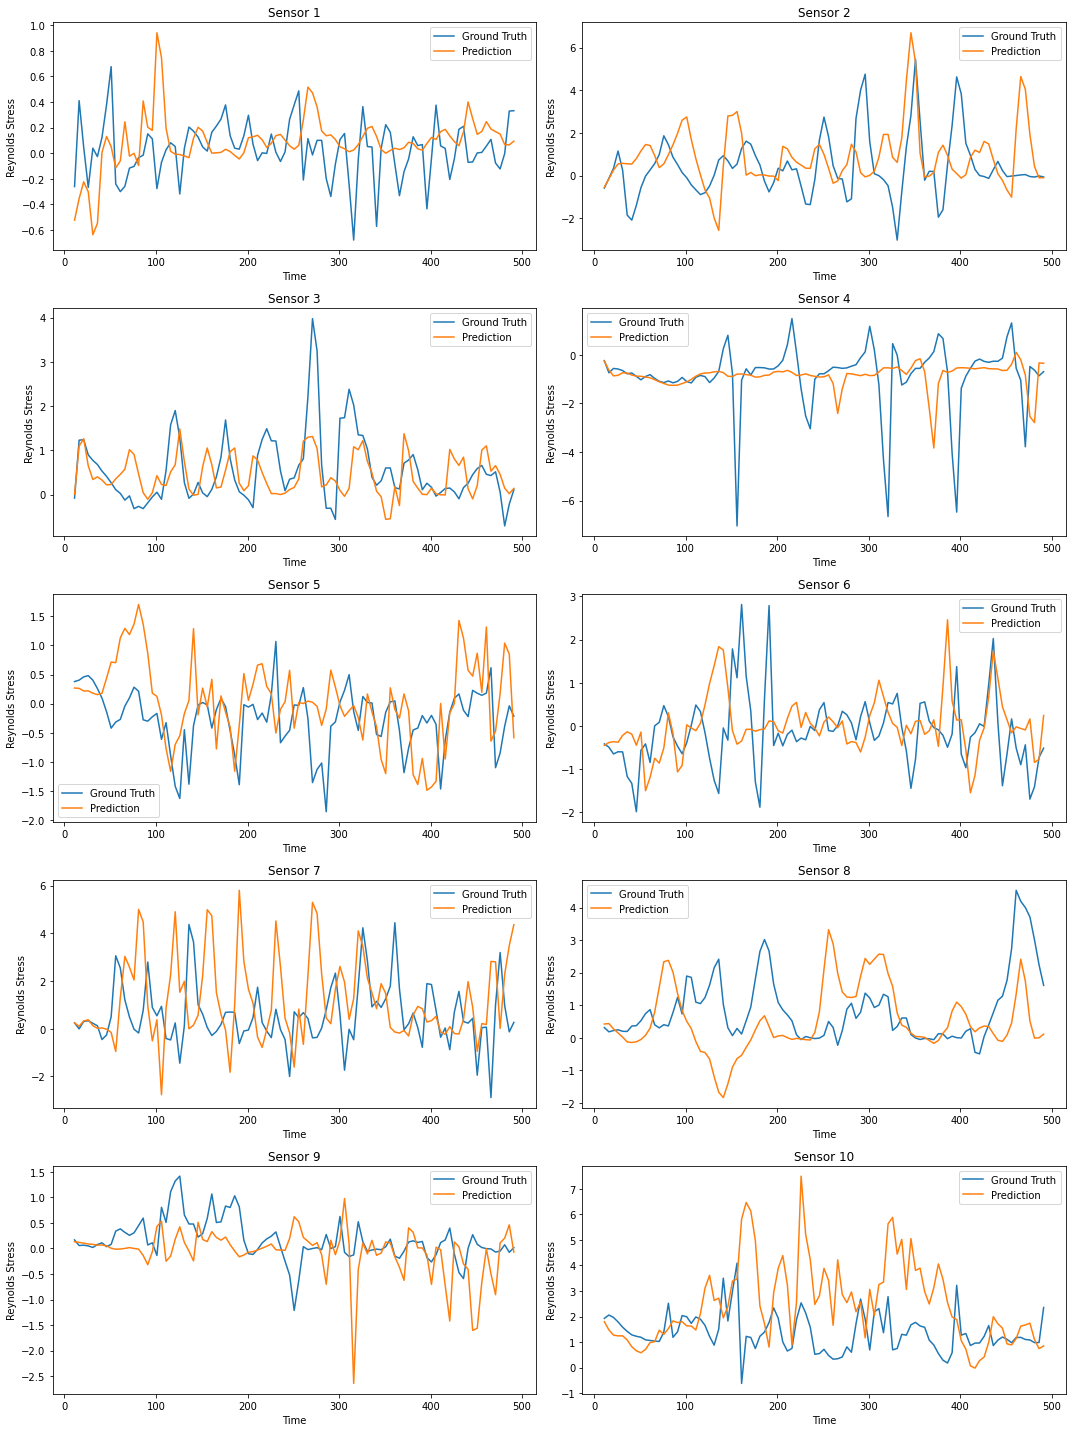

In [173]:
# Number of sensors
num_sensors = 10

# Create a figure with 10 subplots (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(num_sensors):
    # Calculate row and column index for current subplot
    row = i // 2
    col = i % 2

    # Plot Reynolds stress for current sensor
    axs[row, col].plot(timelevels, reynolds_stress_Ytarget_values[:, i], label='Ground Truth')
    axs[row, col].plot(timelevels, reynolds_stress_prediction_values[:, i], label='Prediction')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Reynolds Stress')
    axs[row, col].legend()
    axs[row, col].set_title(f'Sensor {i+1}')

# Adjust layout for better spacing
fig.tight_layout()
plt.show()

In [174]:
print(len(timelevels))

97


In [175]:
print(reynolds_stress_Ytarget_values.shape)

(97, 10)


In [176]:
print(n_list)

[86]


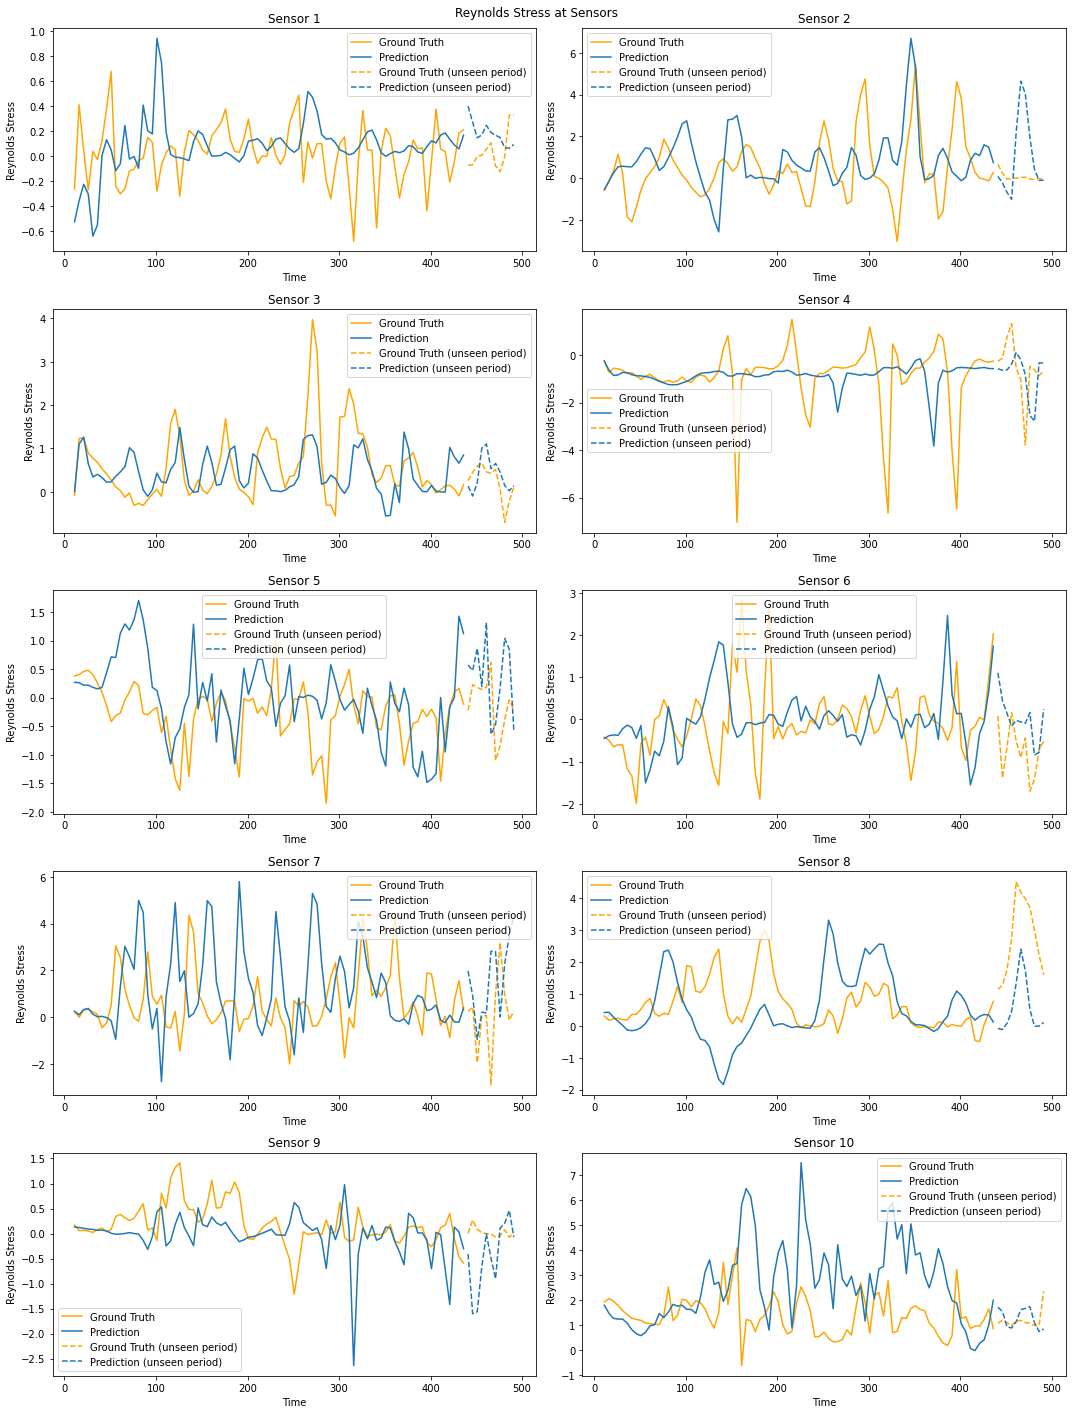

In [190]:
# Number of sensors
num_sensors = 10

# Create a figure with 10 subplots (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(num_sensors):
    # Calculate row and column index for current subplot
    row = i // 2
    col = i % 2

    # Plot Reynolds stress for current sensor
    axs[row, col].plot(timelevels[:n_list[0]], reynolds_stress_Ytarget_values[:n_list[0], i], color='orange',label='Ground Truth')
    axs[row, col].plot(timelevels[:n_list[0]], reynolds_stress_prediction_values[:n_list[0], i], color='tab:blue',label='Prediction')

    # Plot the lastn_list[0] periods in dash lines
    axs[row, col].plot(timelevels[n_list[0]:], reynolds_stress_Ytarget_values[n_list[0]:, i], '--', color='orange',label='Ground Truth (unseen period)')
    axs[row, col].plot(timelevels[n_list[0]:], reynolds_stress_prediction_values[n_list[0]:, i], '--', color='tab:blue',label='Prediction (unseen period)')

    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Reynolds Stress')
    axs[row, col].legend()
    axs[row, col].set_title(f'Sensor {i+1}')

# Add a title to the entire figure
fig.suptitle('Reynolds Stress at Sensors')

# Adjust layout for better spacing
fig.tight_layout()
plt.show()

## Mean flows

In [178]:
import pandas as pd

# Create a dictionary with your data
data = {
    'Time Levels': timelevels,
    'Mean Prediction u': mean_values_prediction_u,
    'Mean Ground Truth u': mean_values_Ytarget_u,
    'Mean Prediction v': mean_values_prediction_v,
    'Mean Ground Truth v': mean_values_Ytarget_v,
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    Time Levels  Mean Prediction u  Mean Ground Truth u  Mean Prediction v  \
0            11           0.979044             0.972587          -0.022415   
1            16           0.970208             0.964171          -0.046792   
2            21           0.953523             0.959307          -0.073815   
3            26           0.933613             0.954396          -0.099897   
4            31           0.913418             0.950492          -0.123648   
..          ...                ...                  ...                ...   
92          471           0.917728             0.917054          -0.174527   
93          476           0.918442             0.917778          -0.172670   
94          481           0.919399             0.919136          -0.167669   
95          486           0.922226             0.920009          -0.162210   
96          491           0.923660             0.919798          -0.159890   

    Mean Ground Truth v  
0             -0.008971  
1          

In [179]:
latex_table = df.to_latex(index=False)

print(latex_table)

\begin{tabular}{rrrrr}
\toprule
 Time Levels &  Mean Prediction u &  Mean Ground Truth u &  Mean Prediction v &  Mean Ground Truth v \\
\midrule
          11 &           0.979044 &             0.972587 &          -0.022415 &            -0.008971 \\
          16 &           0.970208 &             0.964171 &          -0.046792 &            -0.014825 \\
          21 &           0.953523 &             0.959307 &          -0.073815 &            -0.018498 \\
          26 &           0.933613 &             0.954396 &          -0.099897 &            -0.022991 \\
          31 &           0.913418 &             0.950492 &          -0.123648 &            -0.027447 \\
          36 &           0.894917 &             0.946382 &          -0.143373 &            -0.031928 \\
          41 &           0.878592 &             0.942953 &          -0.159849 &            -0.035084 \\
          46 &           0.866520 &             0.939703 &          -0.172810 &            -0.036294 \\
          51 &         

/tmp/ipykernel_130549/2769286486.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


In [180]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (97, 10, 2)
Shape of numpy_array_X1: (97, 10, 2)
Shape of numpy_array_X2: (97, 10, 2)
Shape of numpy_array_Ytarget: (97, 10, 2)
Shape of numpy_array_timelevels: (97,)


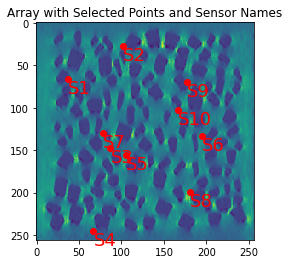

In [181]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


In [182]:
velocity_field_names = ["U", "V"]

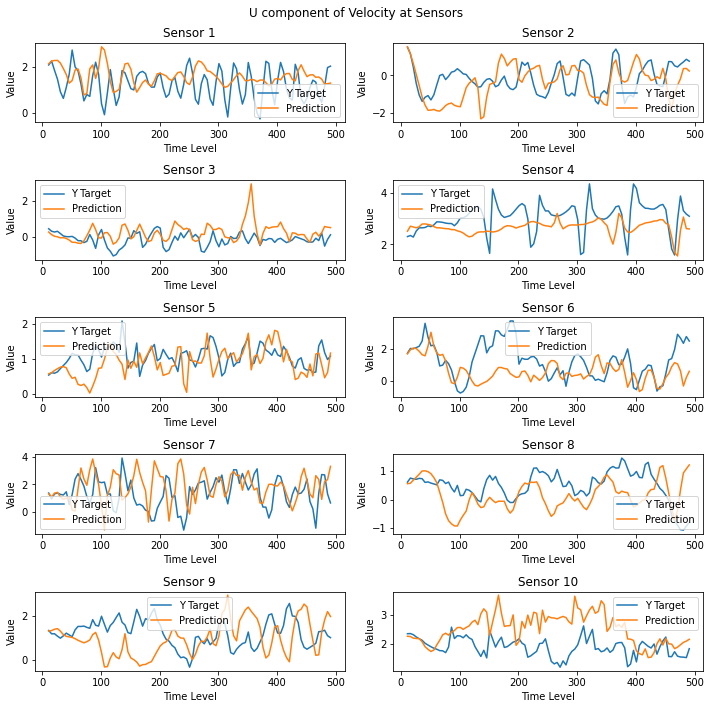

In [183]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

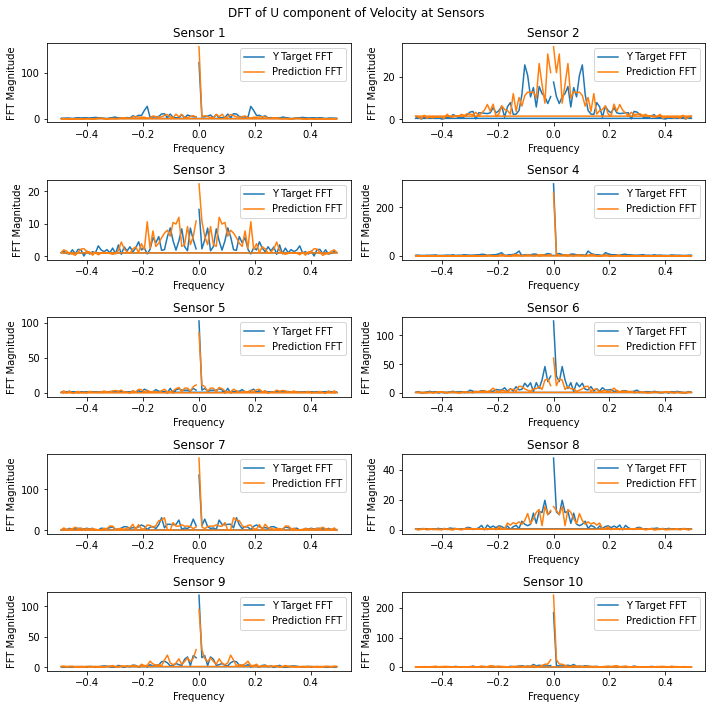

In [184]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Compute the FFT of the samples
    y_target_fft = np.fft.fft(y_target_sample)
    prediction_fft = np.fft.fft(prediction_sample)

    # Compute the frequencies associated with the FFT values
    freq = np.fft.fftfreq(len(y_target_sample))

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot FFT of Y target and prediction in the subplot
    axs[row, col].plot(freq, np.abs(y_target_fft), label='Y Target FFT')
    axs[row, col].plot(freq, np.abs(prediction_fft), label='Prediction FFT')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('FFT Magnitude')
    axs[row, col].legend()

plt.suptitle('DFT of {} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

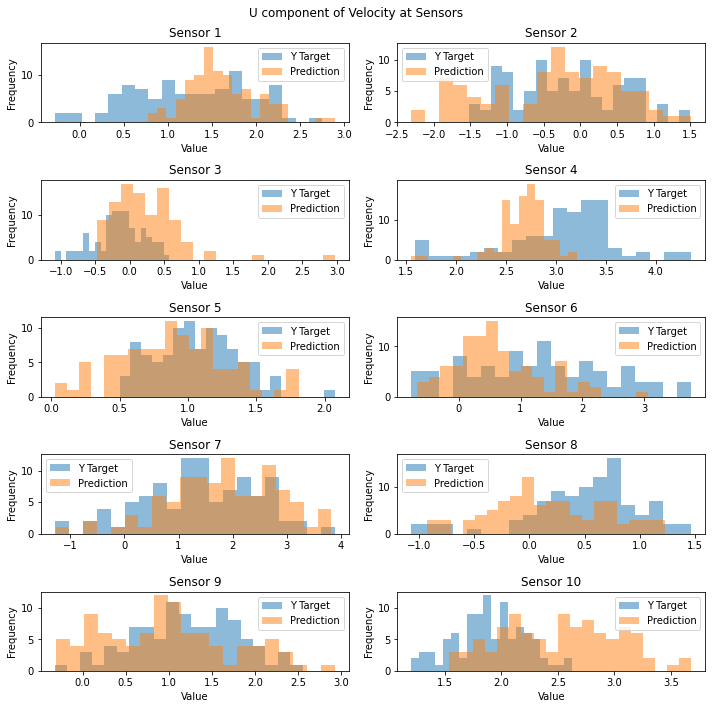

In [185]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].hist(y_target_sample, label='Y Target', alpha=0.5, bins=20)
    axs[row, col].hist(prediction_sample, label='Prediction', alpha=0.5, bins=20)
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

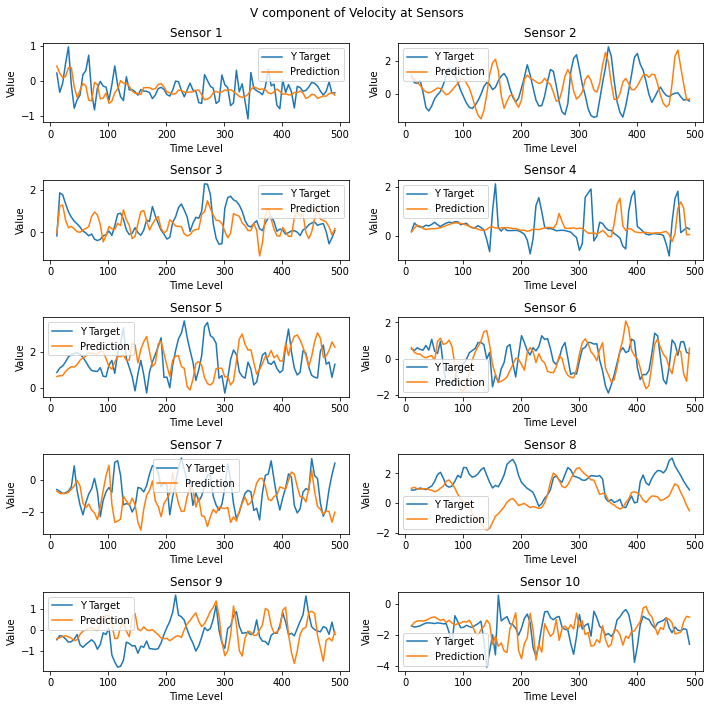

In [186]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

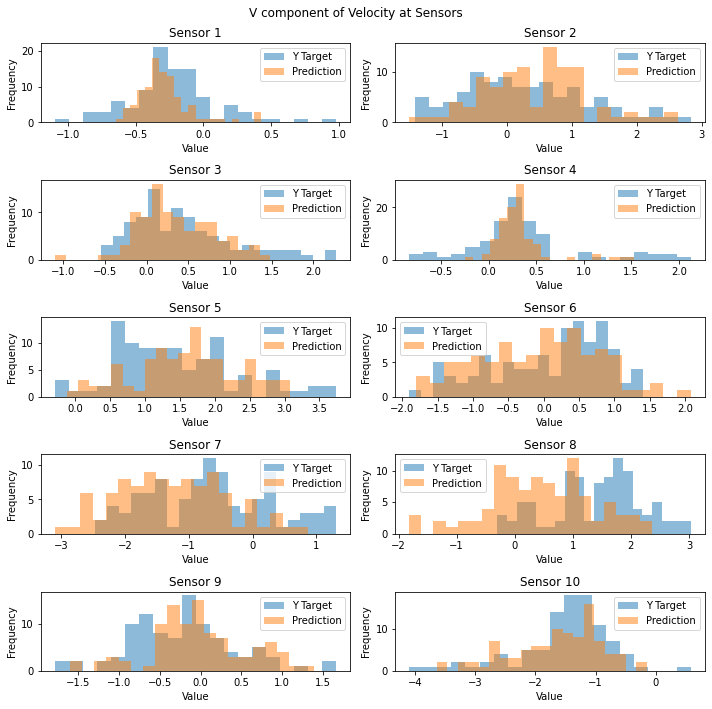

In [187]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].hist(y_target_sample, label='Y Target', alpha=0.5, bins=20)
    axs[row, col].hist(prediction_sample, label='Prediction', alpha=0.5, bins=20)
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

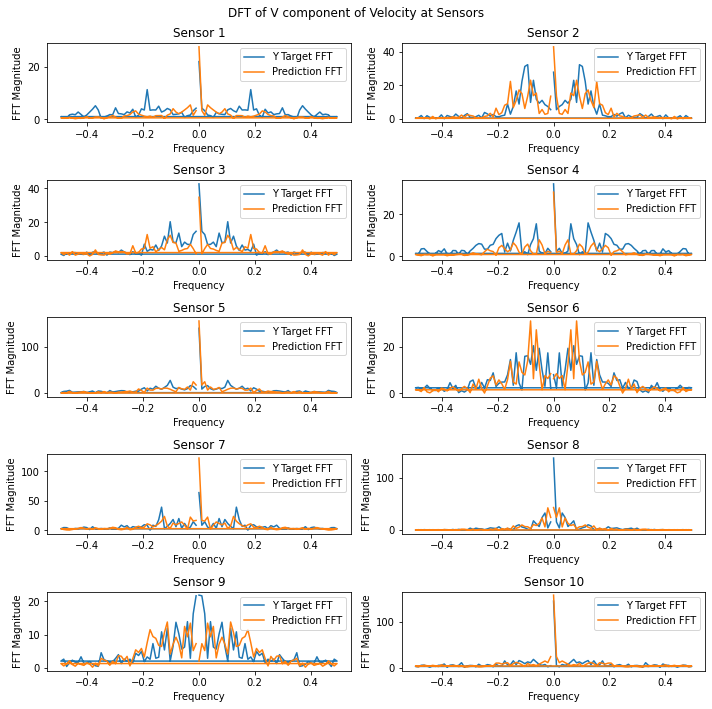

In [188]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Compute the FFT of the samples
    y_target_fft = np.fft.fft(y_target_sample)
    prediction_fft = np.fft.fft(prediction_sample)

    # Compute the frequencies associated with the FFT values
    freq = np.fft.fftfreq(len(y_target_sample))

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot FFT of Y target and prediction in the subplot
    axs[row, col].plot(freq, np.abs(y_target_fft), label='Y Target FFT')
    axs[row, col].plot(freq, np.abs(prediction_fft), label='Prediction FFT')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('FFT Magnitude')
    axs[row, col].legend()

plt.suptitle('DFT of {} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

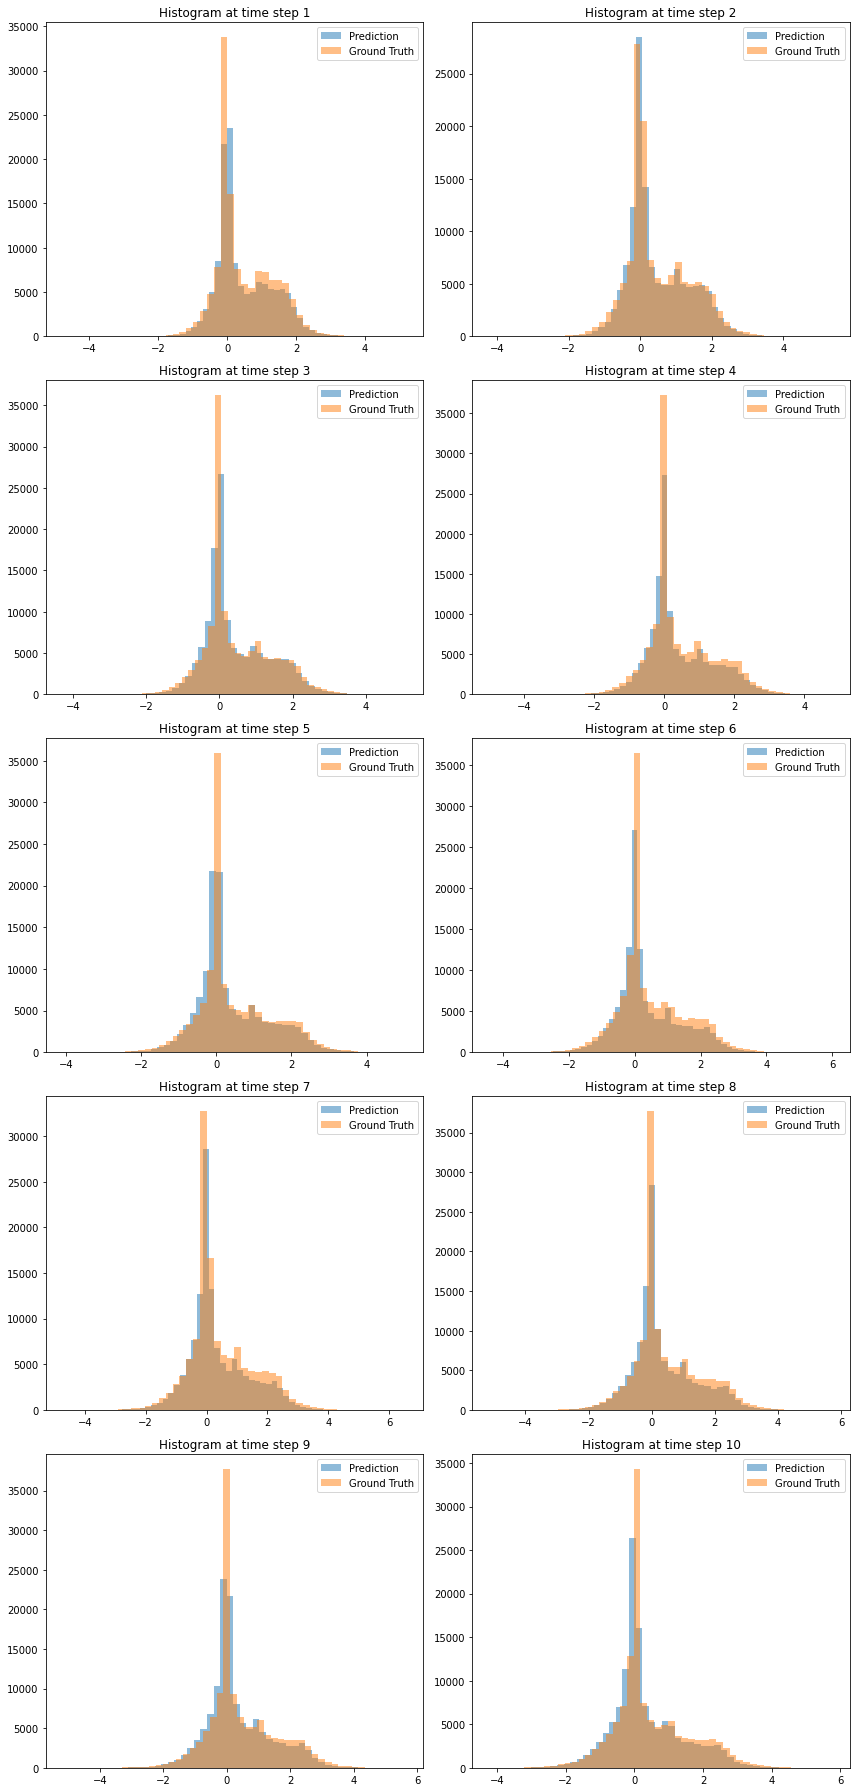

In [189]:
# Calculate the number of rows for the subplots
n = len(hist_data_predictions[:10])
cols = 2
rows = n // cols + (n % cols > 0)

# Create a new figure and a grid of subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 25))

# Flatten the axs array in case we have only one row
axs = axs.flatten()

# Iterate over all subplots and plot the histograms
for i, ax in enumerate(axs):
    if i < n:
        hist_prediction, bins_prediction = hist_data_predictions[i]
        hist_ground_truth, bins_ground_truth = hist_data_ground_truth[i]

        bin_centers_prediction = (bins_prediction[:-1] + bins_prediction[1:]) / 2
        bin_centers_ground_truth = (bins_ground_truth[:-1] + bins_ground_truth[1:]) / 2

        ax.bar(bin_centers_prediction, hist_prediction, width=np.diff(bins_prediction), alpha=0.5, label='Prediction')
        ax.bar(bin_centers_ground_truth, hist_ground_truth, width=np.diff(bins_ground_truth), alpha=0.5, label='Ground Truth')
        ax.legend(loc='upper right')
        ax.set_title('Histogram at time step ' + str(i + 1))
    else:
        # If there is no data, hide the extra subplots
        ax.axis('off')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

# Generate result plots - Larger Domain

In [27]:
def mse_loss(image1, image2):

    mse = np.mean((image1 - image2)**2)
    return mse


### Load CAE model

In [28]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [29]:
sample = Latent_data_Velocity[281]
print(sample.shape)

(32, 96, 96)


In [30]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 96, 96])
(1, 2, 384, 384)


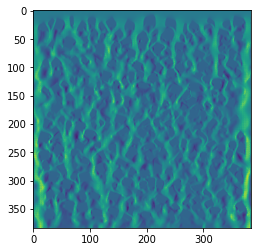

In [31]:
plt.figure()
plt.imshow(output_data[0,0])

### Predict for one sample

In [34]:
sampleX = torch.from_numpy((samples_training_X_stacked[0]).reshape(1,ss_0.shape[1],xysize_latent,xysize_latent)).float()
print(sampleX.shape)

torch.Size([1, 80, 96, 96])


In [35]:
with torch.no_grad():
    aae_model.cpu().eval()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

(32, 96, 96)


(array([1.29140e+04, 1.62817e+05, 8.62250e+04, 2.53840e+04, 5.11900e+03,
        1.80000e+03, 4.98000e+02, 1.23000e+02, 2.80000e+01, 4.00000e+00]),
 array([-0.69820434,  0.50181574,  1.7018358 ,  2.901856  ,  4.101876  ,
         5.301896  ,  6.501916  ,  7.7019362 ,  8.901957  , 10.101976  ,
        11.301996  ], dtype=float32),
 <BarContainer object of 10 artists>)

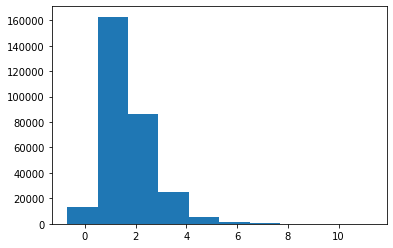

In [36]:
prediction = prediction[0].cpu().detach().numpy()
print(prediction.shape)
plt.hist(prediction.flatten())

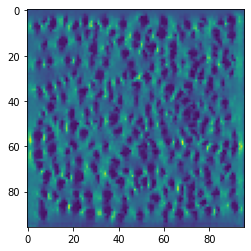

In [37]:
plt.imshow(prediction[0])

(32, 96, 96)
(2, 384, 384)


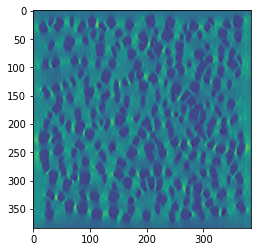

In [38]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
input_data = prediction
print(input_data.shape)
res = autoencoder.decoder(torch.from_numpy(input_data))
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0])

### Predict for training

In [39]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    print(prediction.shape)

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [40]:
for i in range(1,18,1):
    plot_results_together(i)

torch.Size([32, 96, 96])


RuntimeError: Given transposed=1, weight of size [32, 32, 2, 2], expected input[1, 1, 96, 96] to have 32 channels, but got 1 channels instead

### Predict for test

In [41]:
# test set
# Latent_data_Velocity_test = Latent_data_Velocity[timesteps - 50:,:,:,:]
Latent_data_Velocity_test = Latent_data_Velocity[450:,:,:,:]
print(Latent_data_Velocity_test.shape)

(0, 32, 96, 96)


In [42]:
xysize_latent = 64

In [43]:
n_sampels = 30
t_gaps_sampels = 1
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X

    ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    # ss_1 = ss_0


    ss = (ss_0, ss_1)
    # print(ss[0].shape)
    # print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
# print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
# print(samples_test_Y_stacked.shape)

IndexError: index 2 is out of bounds for axis 0 with size 0

In [44]:
# Plot the results together

def plot_results_together(id_sample, velocity_field):
    velocity_field = velocity_field

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # change here to switch models
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

In [45]:
for i in range(1,30):
    plot_results_together(i, 0)

NameError: name 'samples_test_X_stacked' is not defined

# Predict for the whole period - Larger Domain

In [41]:
# autoencoderP = aae_model
# change training or test in the next cell

In [44]:

id_sample = 1
number_samples = 24

rho = 1

timelevels = []
sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []

hist_data_predictions = []
hist_data_ground_truth = []
fft_data_predictions = []
fft_data_ground_truth = []

mean_values_Ytarget_u = []
mean_values_Ytarget_v = []
mean_values_prediction_u = []
mean_values_prediction_v = []

# Initialize lists to store Reynolds stress values
reynolds_stress_Ytarget_values = []
reynolds_stress_prediction_values = []

# sampleX = samples_training_X_stacked[id_sample]
# sampleY = samples_training_Y_stacked[id_sample]
sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[:32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[32:32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

# timelevel = 450 + id_sample*t_gaps_sampels + dt*2
timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[:,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
if isinstance(prediction, tuple):
    prediction = prediction[0]

prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


# get histogram
hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

hist_data_predictions.append((hist_prediction, bins_prediction))
hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

# get FFT
fft_prediction = np.fft.fft2(prediction_decoded)
fft_ground_truth = np.fft.fft2(Y_decoded)

fft_data_predictions.append(fft_prediction)
fft_data_ground_truth.append(fft_ground_truth)

# mean values
# Calculate and store the mean values for the ground truth
print(Y_decoded.shape)
print(prediction_decoded.shape)

mean_Ytarget_u = np.mean(Y_decoded[0, 0, :, :])
mean_Ytarget_v = np.mean(Y_decoded[0, 1, :, :])
mean_values_Ytarget_u.append(mean_Ytarget_u)
mean_values_Ytarget_v.append(mean_Ytarget_v)

mean_prediction_u = np.mean(prediction_decoded[0, 0, :, :])
mean_prediction_v = np.mean(prediction_decoded[0, 1, :, :])
mean_values_prediction_u.append(mean_prediction_u)
mean_values_prediction_v.append(mean_prediction_v)

# Calculate fluctuating components for ground truth at sensor locations
u_fluct_Ytarget = Y_decoded[0, 0, sensors_x, sensors_y] - mean_Ytarget_u
v_fluct_Ytarget = Y_decoded[0, 1, sensors_x, sensors_y] - mean_Ytarget_v

# Calculate Reynolds stress for ground truth at sensor locations
reynolds_stress_Ytarget = -rho * u_fluct_Ytarget * v_fluct_Ytarget
reynolds_stress_Ytarget_values.append(reynolds_stress_Ytarget)

# Calculate fluctuating components for prediction at sensor locations
u_fluct_prediction = prediction_decoded[0, 0, sensors_x, sensors_y] - mean_prediction_u
v_fluct_prediction = prediction_decoded[0, 1, sensors_x, sensors_y] - mean_prediction_v

# Calculate Reynolds stress for prediction at sensor locations
reynolds_stress_prediction = -rho * u_fluct_prediction * v_fluct_prediction
reynolds_stress_prediction_values.append(reynolds_stress_prediction)

# get sensor data
sensor_values_prediction.append(prediction_decoded[0,:, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,:, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,:, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,:, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)

# plt.figure()

# f, axarr = plt.subplots(1,4, figsize=(18, 9))

# # plot latent space
# # sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# # axarr[0].title.set_text('Latent X1')

# # sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# # axarr[1].title.set_text('Latent X2')

# # sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# # axarr[2].title.set_text('Latent Y_Target')

# # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# # axarr[3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[0].imshow(X1_decoded[0][:], interpolation='none')
# axarr[0].title.set_text('X1')

# sub12 = axarr[1].imshow(X2_decoded[0][:], interpolation='none')
# axarr[1].title.set_text('X2')

# sub13 = axarr[2].imshow(Y_decoded[0][:], interpolation='none')
# axarr[2].title.set_text('Y_Target')

# sub14 = axarr[3].imshow(prediction_decoded[0][:], interpolation='none')
# axarr[3].title.set_text('Y_Prediction')


for n in range(number_samples):    
    sampleX_new = sampleX.copy()
    sampleX_new[:32] = sampleX[32:64]
    sampleX_new[32:64] = (prediction.detach().numpy())[0]

    sampleY_new = Latent_data_Velocity_training[1 + id_sample*t_gaps_sampels + dt*(4 + n)]

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[:32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[32:32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    timelevel = timelevel + dt
    timelevels.append(timelevel)
    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())
    if isinstance(prediction, tuple):
        prediction = prediction[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, :, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    # get histogram
    hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
    hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

    hist_data_predictions.append((hist_prediction, bins_prediction))
    hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

    # get FFT
    fft_prediction = np.fft.fft2(prediction_decoded)
    fft_ground_truth = np.fft.fft2(Y_decoded)

    fft_data_predictions.append(fft_prediction)
    fft_data_ground_truth.append(fft_ground_truth)


    # mean values
    # Calculate and store the mean values for the ground truth
    mean_Ytarget_u = np.mean(Y_decoded[0, 0, :, :])
    mean_Ytarget_v = np.mean(Y_decoded[0, 1, :, :])
    mean_values_Ytarget_u.append(mean_Ytarget_u)
    mean_values_Ytarget_v.append(mean_Ytarget_v)

    mean_prediction_u = np.mean(prediction_decoded[0, 0, :, :])
    mean_prediction_v = np.mean(prediction_decoded[0, 1, :, :])
    mean_values_prediction_u.append(mean_prediction_u)
    mean_values_prediction_v.append(mean_prediction_v)

    # Calculate fluctuating components for ground truth at sensor locations
    u_fluct_Ytarget = Y_decoded[0, 0, sensors_x, sensors_y] - mean_Ytarget_u
    v_fluct_Ytarget = Y_decoded[0, 1, sensors_x, sensors_y] - mean_Ytarget_v

    # Calculate Reynolds stress for ground truth at sensor locations
    reynolds_stress_Ytarget = -rho * u_fluct_Ytarget * v_fluct_Ytarget
    reynolds_stress_Ytarget_values.append(reynolds_stress_Ytarget)

    # Calculate fluctuating components for prediction at sensor locations
    u_fluct_prediction = prediction_decoded[0, 0, sensors_x, sensors_y] - mean_prediction_u
    v_fluct_prediction = prediction_decoded[0, 1, sensors_x, sensors_y] - mean_prediction_v

    # Calculate Reynolds stress for prediction at sensor locations
    reynolds_stress_prediction = -rho * u_fluct_prediction * v_fluct_prediction
    reynolds_stress_prediction_values.append(reynolds_stress_prediction)


    
    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,:, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,:, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,:, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,:, sensors_x, sensors_y])


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # # plot latent space
    # # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # # axarr[0].title.set_text('Latent X1')

    # # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # # axarr[1].title.set_text('Latent X2')

    # # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # # axarr[2].title.set_text('Latent Y_Target')

    # # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # # axarr[3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][:], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][:], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][:], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][:], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

(1, 2, 384, 384)
(1, 2, 384, 384)
prediction error: 0.028327767
prediction error: 0.0814984
prediction error: 0.12424444
prediction error: 0.18108167
prediction error: 0.2499264
prediction error: 0.3283347
prediction error: 0.41539824
prediction error: 0.5089642
prediction error: 0.6096777
prediction error: 0.7109718
prediction error: 0.79843223
prediction error: 0.8714445
prediction error: 0.9403688
prediction error: 1.0155064
prediction error: 1.0857847
prediction error: 1.144751
prediction error: 1.1842021
prediction error: 1.2163213
prediction error: 1.2522645
prediction error: 1.2846937
prediction error: 1.3145647
prediction error: 1.3383427
prediction error: 1.3611169
prediction error: 1.3998027
prediction error: 1.4381365


## Reynolds stresses

In [45]:
reynolds_stress_Ytarget_values = np.stack(reynolds_stress_Ytarget_values)
print(reynolds_stress_Ytarget_values.shape)

(25, 10)


In [46]:
reynolds_stress_prediction_values = np.stack(reynolds_stress_prediction_values)
print(reynolds_stress_prediction_values.shape)

(25, 10)


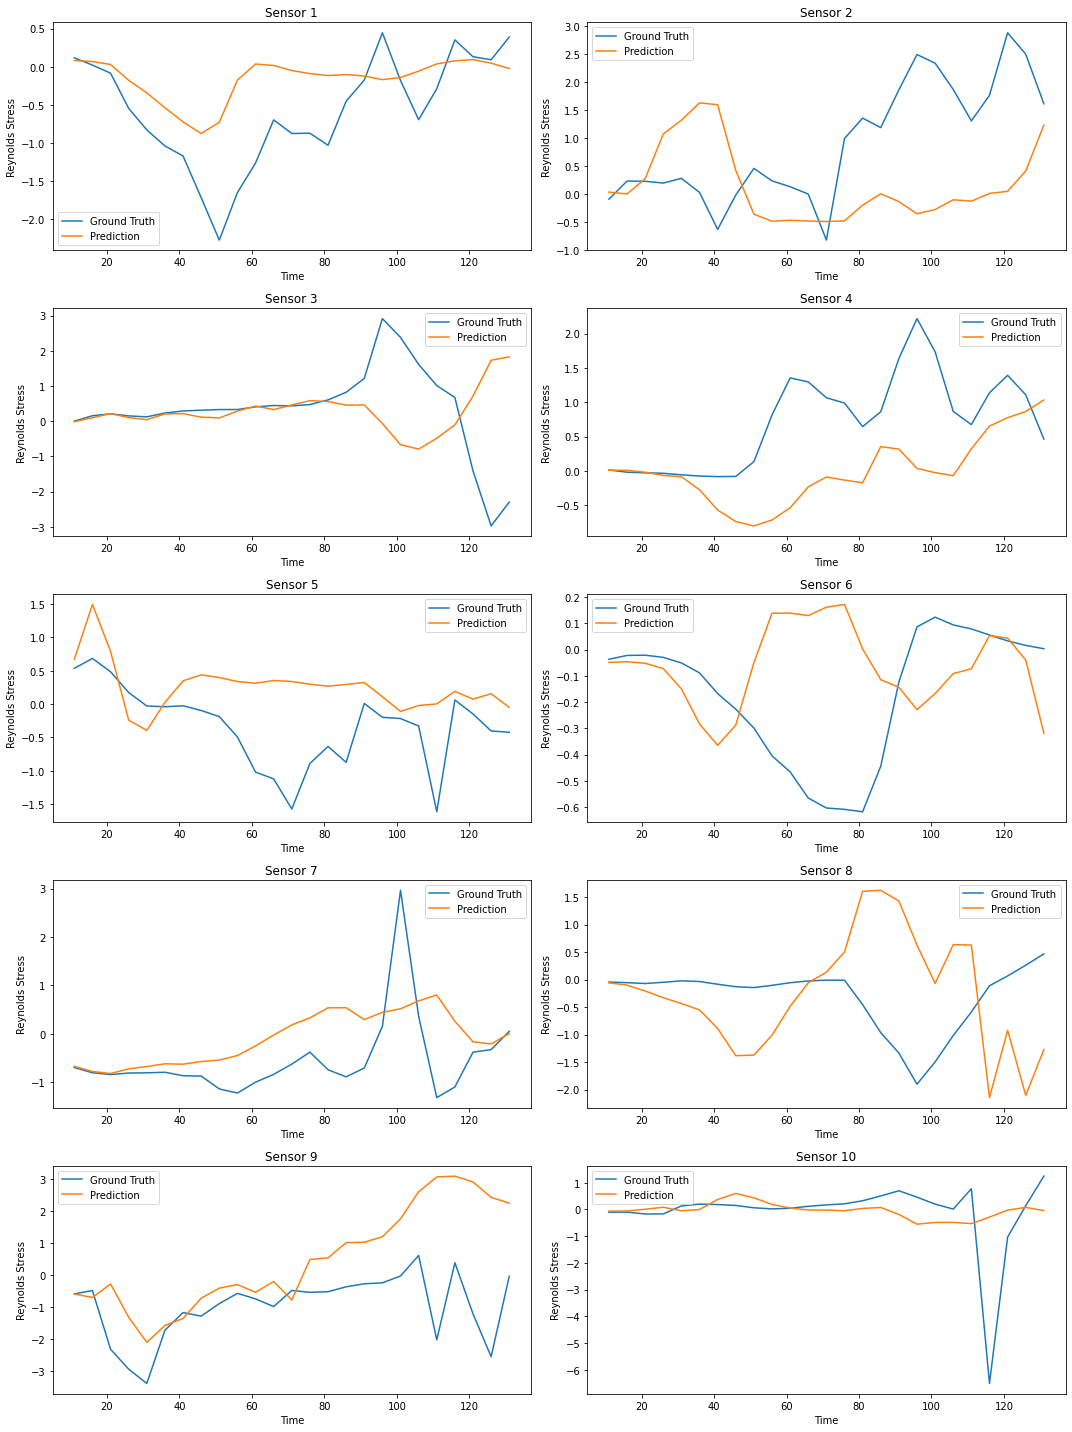

In [47]:
# Number of sensors
num_sensors = 10

# Create a figure with 10 subplots (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(num_sensors):
    # Calculate row and column index for current subplot
    row = i // 2
    col = i % 2

    # Plot Reynolds stress for current sensor
    axs[row, col].plot(timelevels, reynolds_stress_Ytarget_values[:, i], label='Ground Truth')
    axs[row, col].plot(timelevels, reynolds_stress_prediction_values[:, i], label='Prediction')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Reynolds Stress')
    axs[row, col].legend()
    axs[row, col].set_title(f'Sensor {i+1}')

# Adjust layout for better spacing
fig.tight_layout()
plt.show()

## Mean flows

In [48]:
import pandas as pd

# Create a dictionary with your data
data = {
    'Time Levels': timelevels,
    'Mean Prediction u': mean_values_prediction_u,
    'Mean Ground Truth u': mean_values_Ytarget_u,
    'Mean Prediction v': mean_values_prediction_v,
    'Mean Ground Truth v': mean_values_Ytarget_v,
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    Time Levels  Mean Prediction u  Mean Ground Truth u  Mean Prediction v  \
0            11           0.981078             0.973366          -0.018604   
1            16           0.971933             0.967099          -0.045668   
2            21           0.953677             0.963224          -0.076715   
3            26           0.929599             0.959263          -0.108490   
4            31           0.902869             0.955470          -0.138823   
5            36           0.877089             0.951803          -0.166515   
6            41           0.854311             0.948432          -0.190959   
7            46           0.835392             0.944903          -0.211964   
8            51           0.820026             0.941373          -0.229964   
9            56           0.808764             0.938451          -0.245258   
10           61           0.800903             0.935813          -0.257273   
11           66           0.795651             0.933625         

In [49]:
latex_table = df.to_latex(index=False)

print(latex_table)

\begin{tabular}{rrrrr}
\toprule
 Time Levels &  Mean Prediction u &  Mean Ground Truth u &  Mean Prediction v &  Mean Ground Truth v \\
\midrule
          11 &           0.981078 &             0.973366 &          -0.018604 &            -0.002150 \\
          16 &           0.971933 &             0.967099 &          -0.045668 &            -0.002282 \\
          21 &           0.953677 &             0.963224 &          -0.076715 &            -0.003123 \\
          26 &           0.929599 &             0.959263 &          -0.108490 &            -0.003890 \\
          31 &           0.902869 &             0.955470 &          -0.138823 &            -0.004456 \\
          36 &           0.877089 &             0.951803 &          -0.166515 &            -0.004865 \\
          41 &           0.854311 &             0.948432 &          -0.190959 &            -0.004962 \\
          46 &           0.835392 &             0.944903 &          -0.211964 &            -0.005167 \\
          51 &         

/tmp/ipykernel_129895/2769286486.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


In [50]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (25, 10, 2)
Shape of numpy_array_X1: (25, 10, 2)
Shape of numpy_array_X2: (25, 10, 2)
Shape of numpy_array_Ytarget: (25, 10, 2)
Shape of numpy_array_timelevels: (25,)


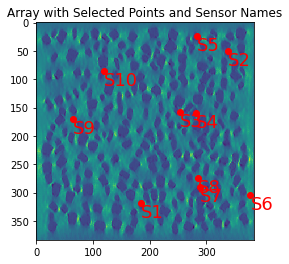

In [51]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


In [52]:
velocity_field_names = ["U", "V"]

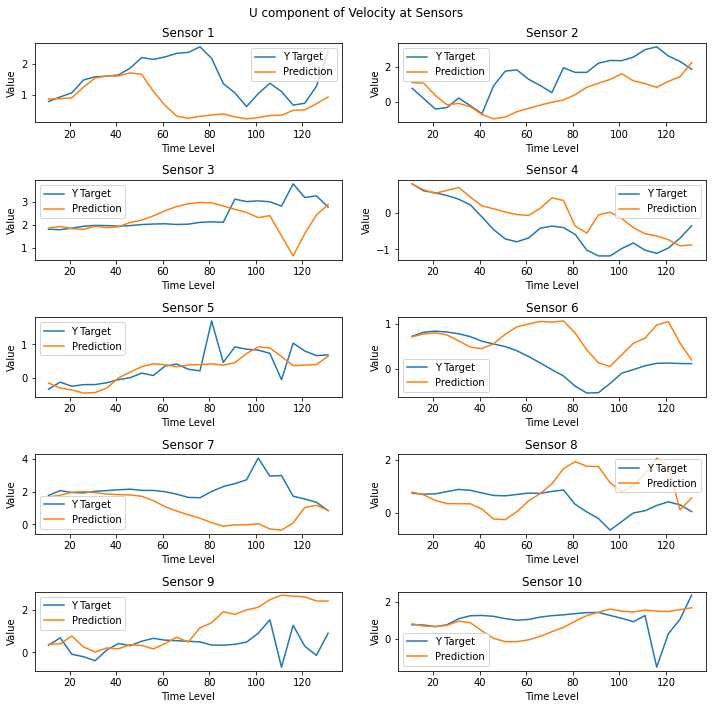

In [60]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

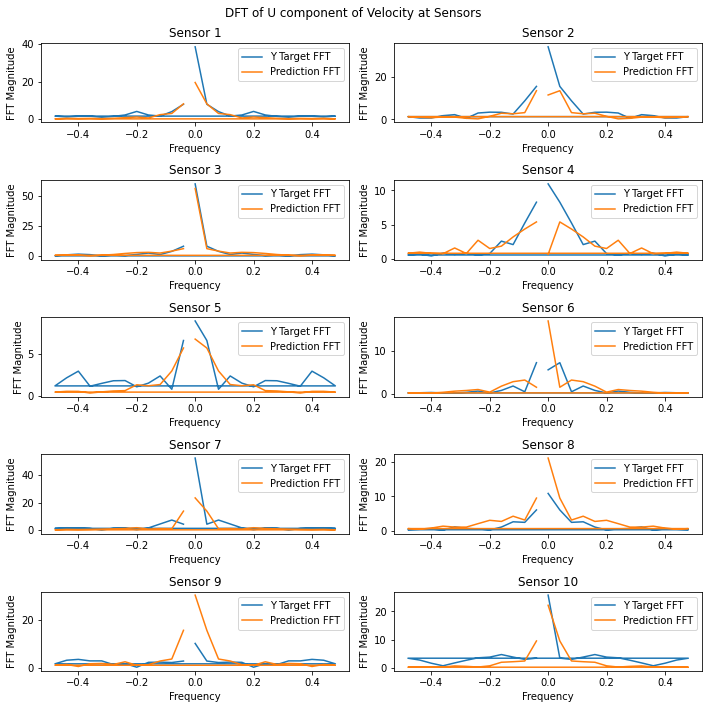

In [63]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Compute the FFT of the samples
    y_target_fft = np.fft.fft(y_target_sample)
    prediction_fft = np.fft.fft(prediction_sample)

    # Compute the frequencies associated with the FFT values
    freq = np.fft.fftfreq(len(y_target_sample))

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot FFT of Y target and prediction in the subplot
    axs[row, col].plot(freq, np.abs(y_target_fft), label='Y Target FFT')
    axs[row, col].plot(freq, np.abs(prediction_fft), label='Prediction FFT')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('FFT Magnitude')
    axs[row, col].legend()

plt.suptitle('DFT of {} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

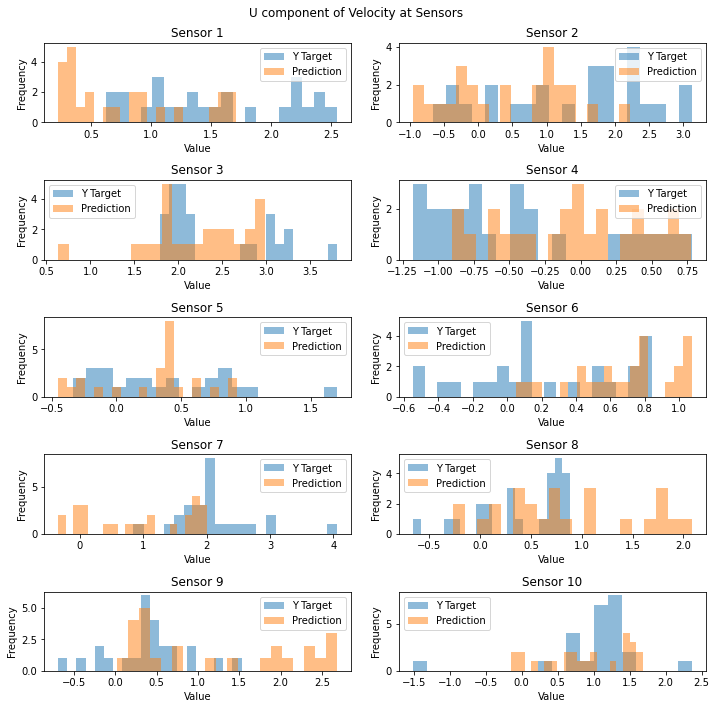

In [59]:
velocity_field = 0

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].hist(y_target_sample, label='Y Target', alpha=0.5, bins=20)
    axs[row, col].hist(prediction_sample, label='Prediction', alpha=0.5, bins=20)
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

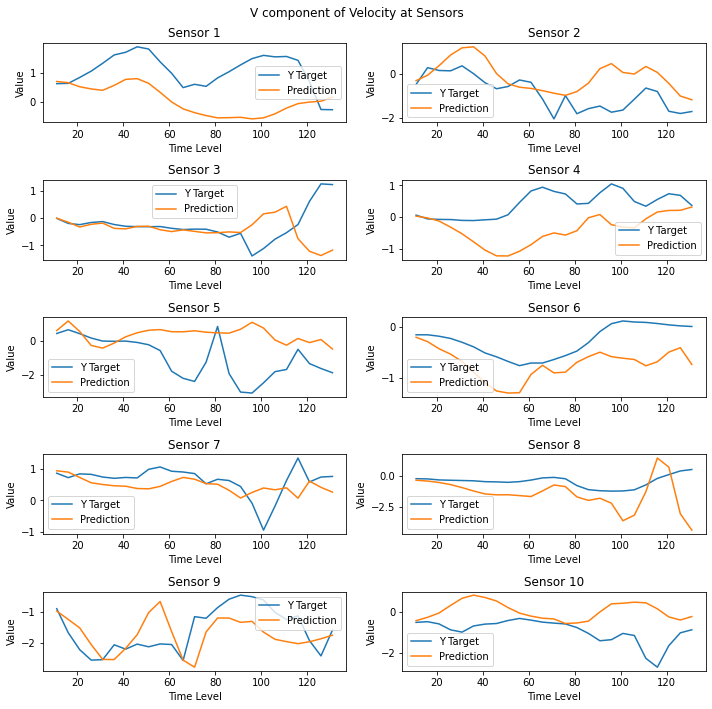

In [61]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

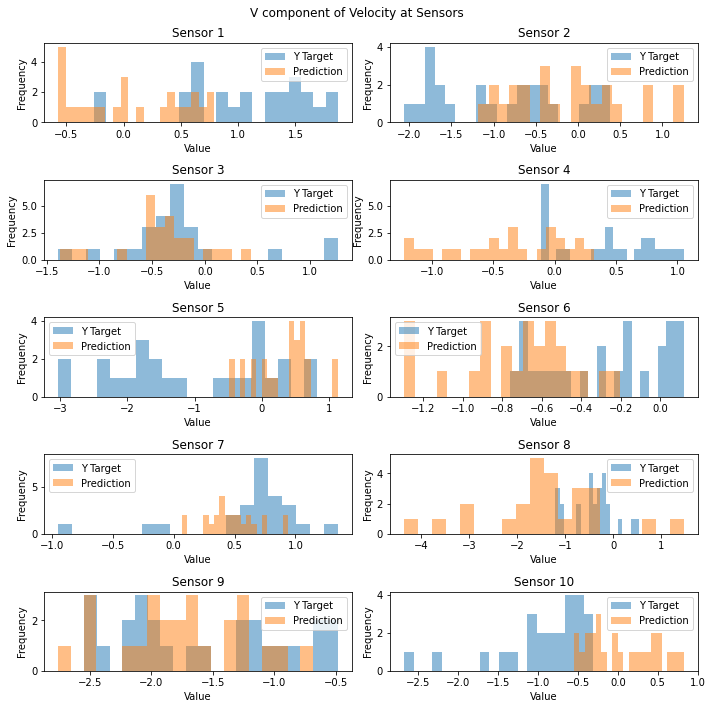

In [62]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].hist(y_target_sample, label='Y Target', alpha=0.5, bins=20)
    axs[row, col].hist(prediction_sample, label='Prediction', alpha=0.5, bins=20)
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].legend()

plt.suptitle('{} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

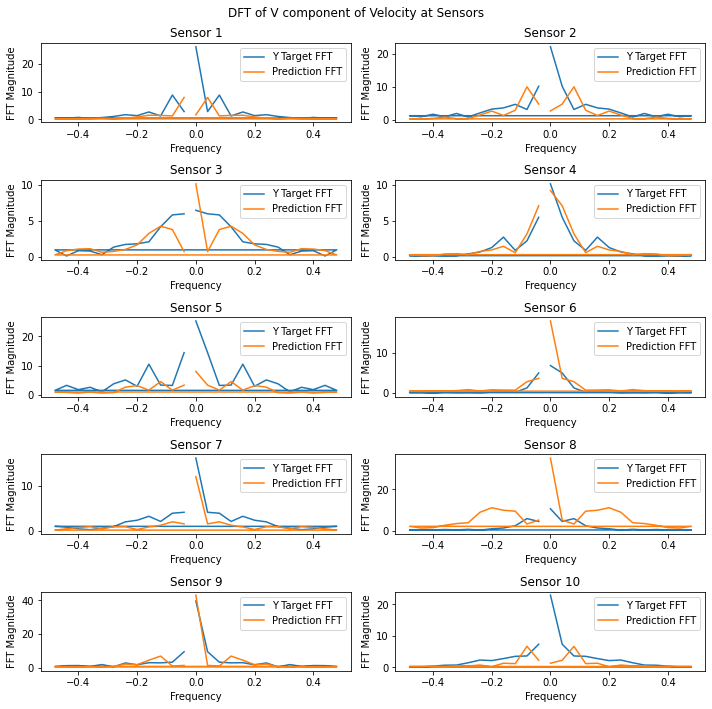

In [64]:
velocity_field = 1

# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i, velocity_field]
    prediction_sample = numpy_array_prediction[:, i, velocity_field]

    # Compute the FFT of the samples
    y_target_fft = np.fft.fft(y_target_sample)
    prediction_fft = np.fft.fft(prediction_sample)

    # Compute the frequencies associated with the FFT values
    freq = np.fft.fftfreq(len(y_target_sample))

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot FFT of Y target and prediction in the subplot
    axs[row, col].plot(freq, np.abs(y_target_fft), label='Y Target FFT')
    axs[row, col].plot(freq, np.abs(prediction_fft), label='Prediction FFT')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('FFT Magnitude')
    axs[row, col].legend()

plt.suptitle('DFT of {} component of Velocity at Sensors'.format(velocity_field_names[velocity_field]))

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

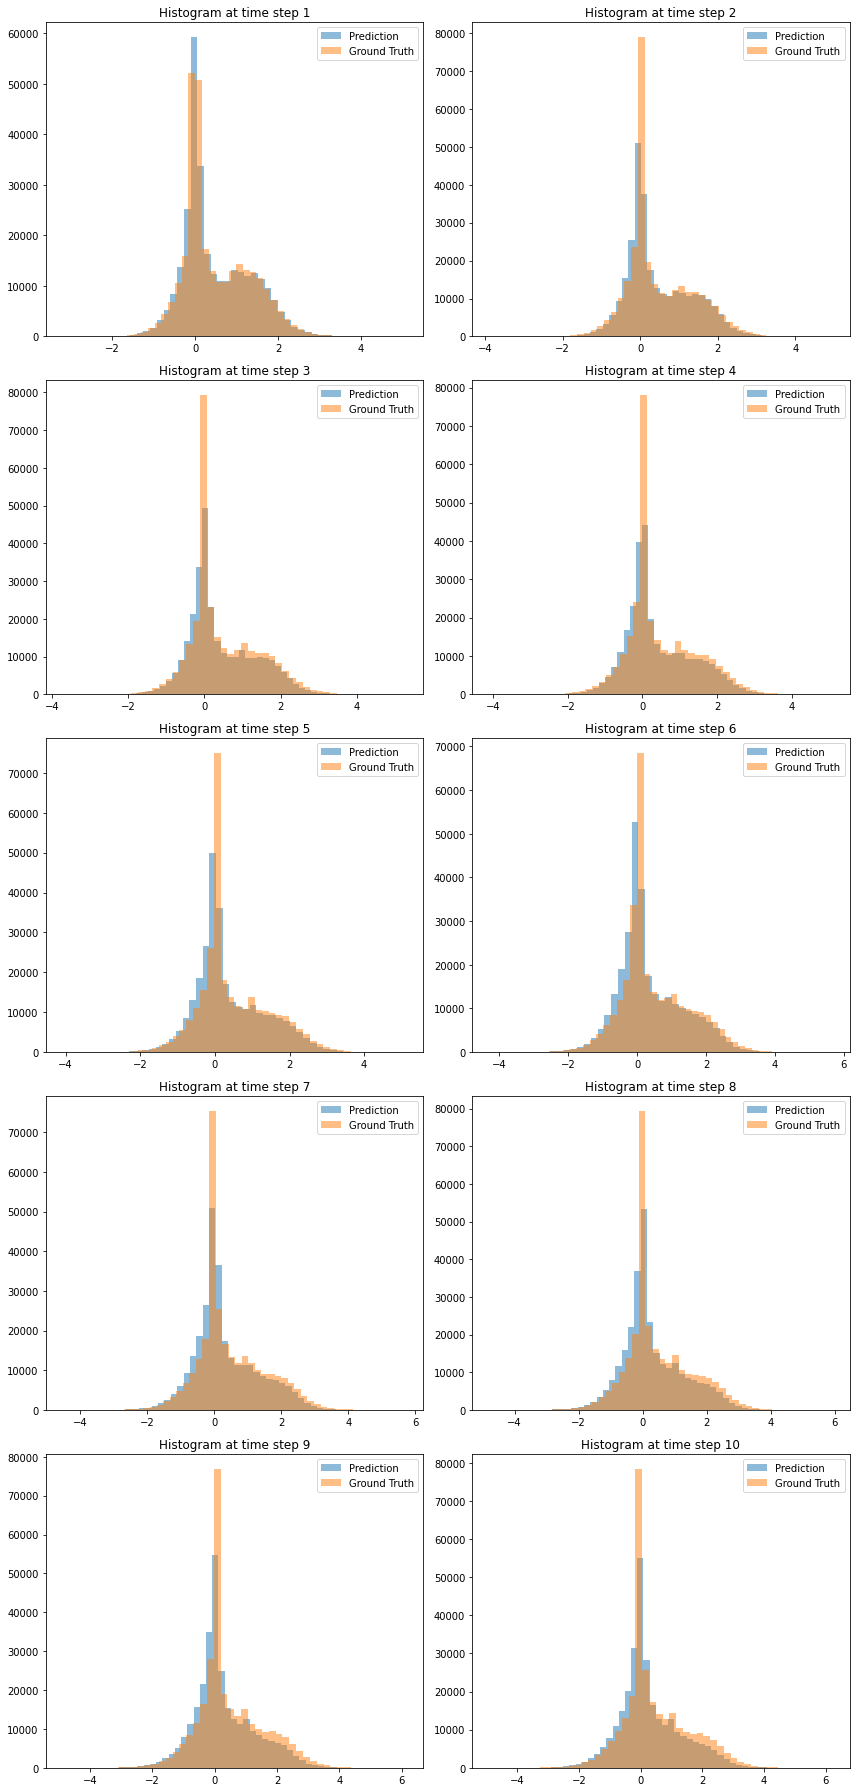

In [108]:
# Calculate the number of rows for the subplots
n = len(hist_data_predictions[:10])
cols = 2
rows = n // cols + (n % cols > 0)

# Create a new figure and a grid of subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 25))

# Flatten the axs array in case we have only one row
axs = axs.flatten()

# Iterate over all subplots and plot the histograms
for i, ax in enumerate(axs):
    if i < n:
        hist_prediction, bins_prediction = hist_data_predictions[i]
        hist_ground_truth, bins_ground_truth = hist_data_ground_truth[i]

        bin_centers_prediction = (bins_prediction[:-1] + bins_prediction[1:]) / 2
        bin_centers_ground_truth = (bins_ground_truth[:-1] + bins_ground_truth[1:]) / 2

        ax.bar(bin_centers_prediction, hist_prediction, width=np.diff(bins_prediction), alpha=0.5, label='Prediction')
        ax.bar(bin_centers_ground_truth, hist_ground_truth, width=np.diff(bins_ground_truth), alpha=0.5, label='Ground Truth')
        ax.legend(loc='upper right')
        ax.set_title('Histogram at time step ' + str(i + 1))
    else:
        # If there is no data, hide the extra subplots
        ax.axis('off')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

In [64]:
print(numpy_array_Ytarget.shape)
print(numpy_array_timelevels.shape)

(21, 10)
(21,)
